In [1]:
from intake import open_catalog

from datetime import datetime
import numpy as np

import matplotlib.pyplot as plt

In [7]:
# Import tobac itself
import tobac
print('using tobac version', str(tobac.__version__))

using tobac version 1.5.5


In [3]:
# Open EUREC4A catalogue to access data
cat = open_catalog("https://raw.githubusercontent.com/eurec4a/eurec4a-intake/master/catalog.yml")

In [4]:
# Open the cloud botany LES catalogue
cloud_botany = cat.simulations.DALES.botany

In [8]:
# Load 2D cloud fields into an xarray dataset
ds = cloud_botany.dx100m.nx1536["2D"].to_dask()
# Supress FutureWarning

In [21]:
lwp_selected = ds.lwp.sel(member= 42,time=slice(datetime(2020,2,2,10), datetime(2020,2,2,14))).compute()

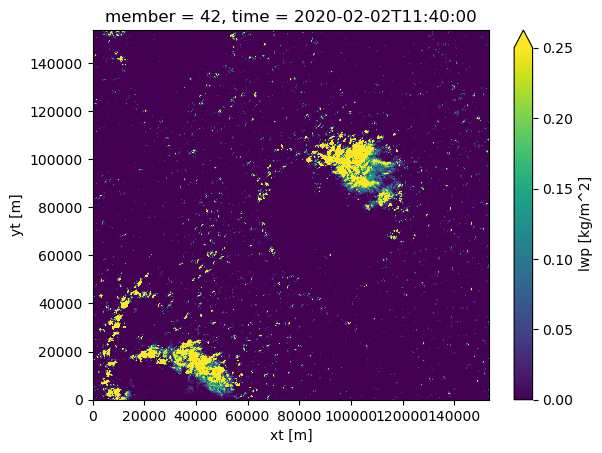

In [22]:
lwp_selected[20].plot(vmax = 0.25)

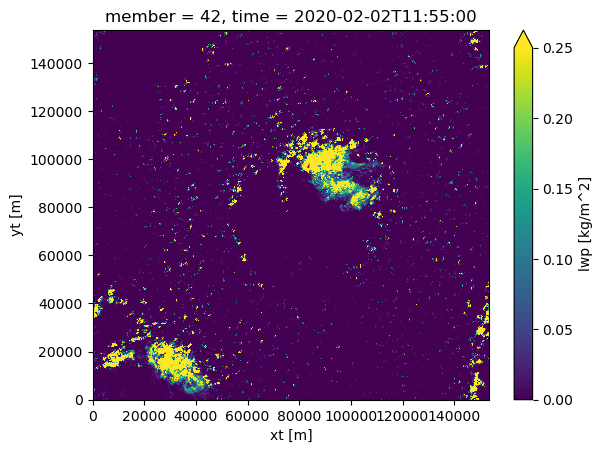

In [25]:
lwp_selected[23].plot(vmax = 0.25)

In [50]:
# Load a subset of LWP for one ensemble member
lwp = ds.sel(member=42, time=slice(datetime(2020,2,2,10), datetime(2020,2,2,14))).lwp.compute()

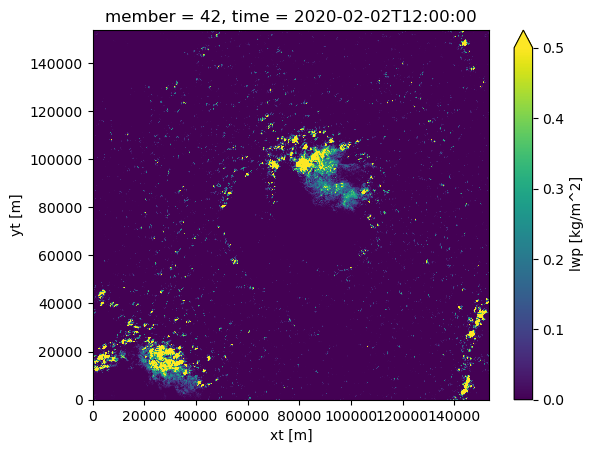

In [53]:
lwp[24].plot(vmax=0.5)

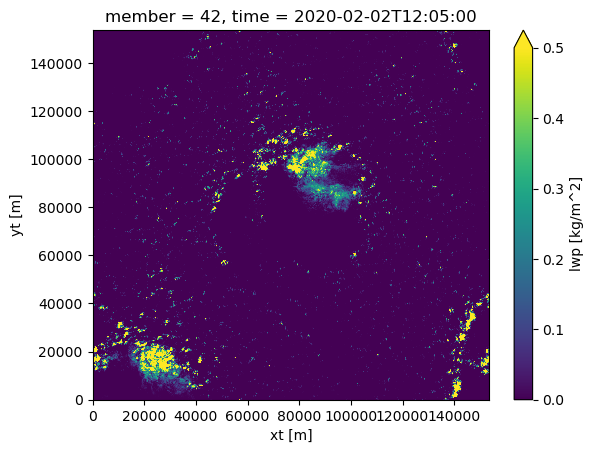

In [54]:
lwp[25].coarsen({"yt":10, "xt":10}.plot(vmax=0.5)

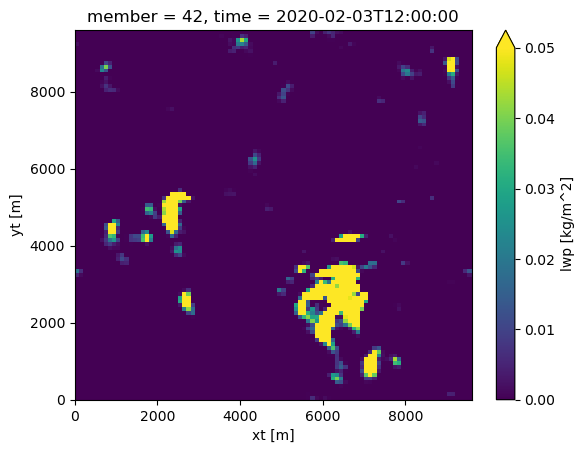

In [8]:
lwp[24].plot(vmax=0.05)

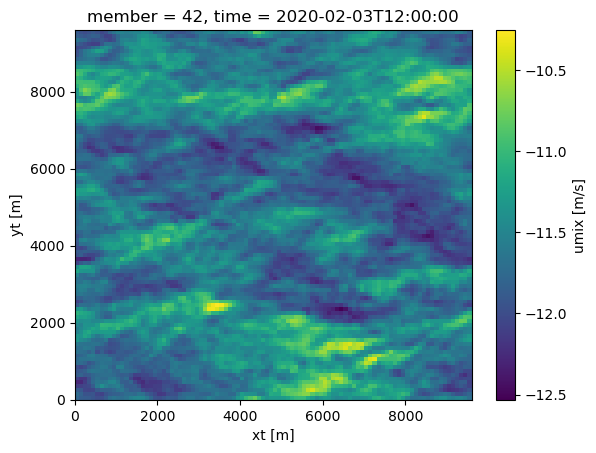

In [46]:
ds.sel(member=42, time=slice(datetime(2020,2,3,10), datetime(2020,2,3,14))).umix[24].plot()

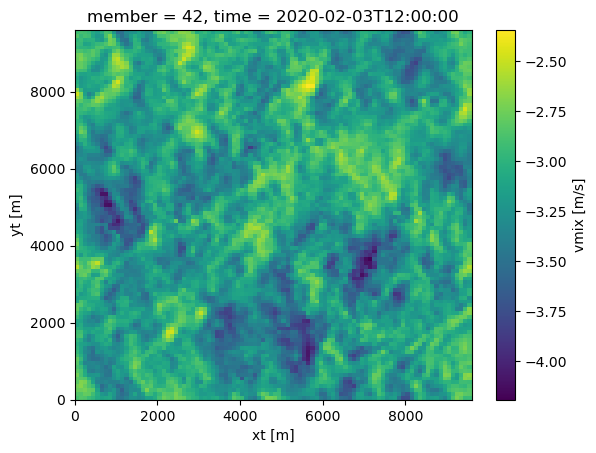

In [47]:
ds.sel(member=42, time=slice(datetime(2020,2,3,10), datetime(2020,2,3,14))).vmix[24].plot()

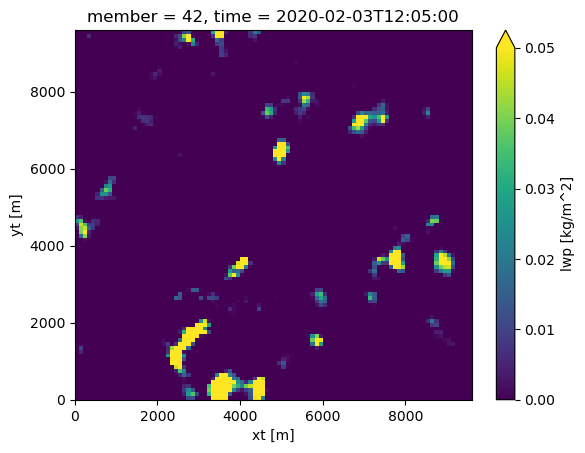

In [9]:
lwp[25].plot(vmax=0.05)

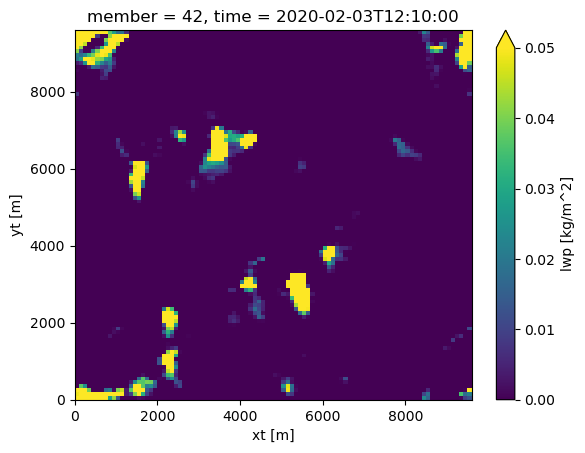

In [10]:
lwp[26].plot(vmax=0.05)

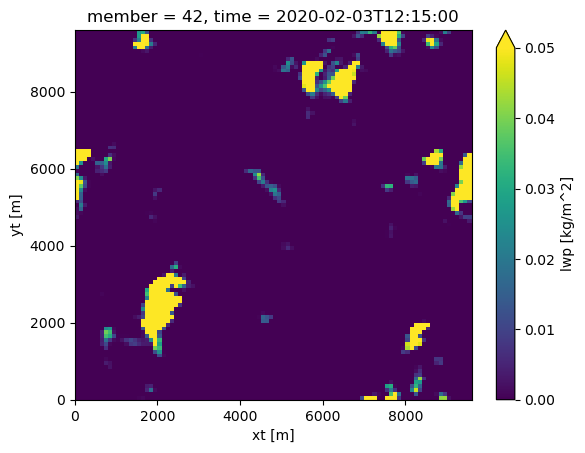

In [11]:
lwp[27].plot(vmax=0.05)

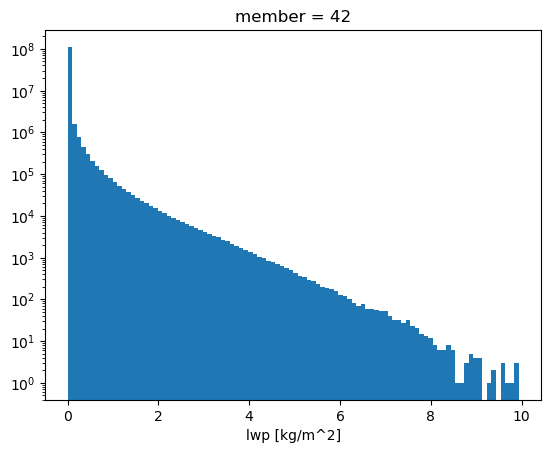

In [26]:
lwp_selected.plot(bins=100)
plt.yscale("log")

In [42]:
# Dictionary containing keyword options (could also be directly given to the function)
dxy, dt = 100, 300
parameters_features={}
parameters_features['threshold']=[1, 2, 5] #kg/m^2
parameters_features['n_min_threshold']= 20
parameters_features['PBC_flag'] ="both"

In [28]:
import warnings

In [29]:
warnings.filterwarnings("ignore", category=FutureWarning)

In [43]:
Features = tobac.feature_detection_multithreshold(lwp_selected, **parameters_features)

In [44]:
Features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,yt,xt,member
0,0,7,85.734378,1114.734362,64,1,1,2020-02-02 10:00:00,2020-02-02 10:00:00,8623.437775,111523.436245,111523.436245
1,0,9,92.918039,1168.967222,61,1,2,2020-02-02 10:00:00,2020-02-02 10:00:00,9341.803914,116946.722180,116946.722180
2,0,10,94.566676,1121.611270,90,1,3,2020-02-02 10:00:00,2020-02-02 10:00:00,9506.667605,112211.127021,112211.127021
3,0,14,108.615384,1127.269230,26,1,4,2020-02-02 10:00:00,2020-02-02 10:00:00,10911.538417,112776.922965,112776.922965
4,0,19,113.772727,913.045455,22,1,5,2020-02-02 10:00:00,2020-02-02 10:00:00,11427.272664,91354.545530,91354.545530
...,...,...,...,...,...,...,...,...,...,...,...,...
3125,48,158,270.923076,1023.192309,26,2,3126,2020-02-02 14:00:00,2020-02-02 14:00:00,27142.307595,102369.230938,102369.230938
3126,48,159,354.333330,874.866661,45,2,3127,2020-02-02 14:00:00,2020-02-02 14:00:00,35483.333003,87536.666135,87536.666135
3127,48,164,1463.388634,550.465014,157,2,3128,2020-02-02 14:00:00,2020-02-02 14:00:00,146388.863443,55096.501440,55096.501440
3128,48,169,232.700004,867.433333,30,5,3129,2020-02-02 14:00:00,2020-02-02 14:00:00,23320.000442,86793.333267,86793.333267


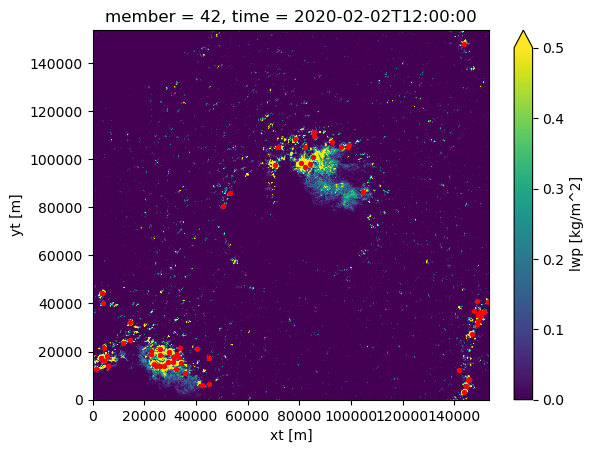

In [45]:
lwp_selected[24].plot(vmax=0.5)
plt.scatter(Features[Features.frame==24].xt, Features[Features.frame==24].yt, c="red", s = 8)

In [46]:
Tracks = tobac.linking_trackpy(
    Features, None, dt=300, dxy=100, v_max=10, method_linking="predict", 
    adaptive_stop=0.2, 
    adaptive_step=0.95, 
    stubs=4,
    # subnetwork_size=100,
    min_h1=0,
    max_h1=1536,
    min_h2=0,
    max_h2=1536,
    PBC_flag='both',
)

Frame 48: 42 trajectories present.


In [50]:
np.unique(Tracks.cell)

array([  -1,    5,   12,   13,   45,   52,   53,   58,   69,   84,   94,
         99,  104,  108,  114,  116,  121,  130,  135,  138,  142,  144,
        153,  161,  162,  163,  169,  177,  179,  180,  186,  190,  193,
        194,  200,  202,  207,  212,  213,  215,  224,  230,  232,  236,
        237,  246,  247,  252,  253,  255,  257,  258,  262,  265,  267,
        268,  271,  273,  275,  280,  281,  288,  291,  292,  295,  296,
        297,  298,  299,  301,  305,  308,  310,  311,  312,  313,  316,
        318,  319,  321,  323,  325,  334,  336,  340,  341,  345,  349,
        350,  351,  352,  358,  360,  364,  365,  369,  379,  382,  396,
        400,  402,  404,  405,  406,  408,  409,  410,  415,  419,  422,
        432,  436,  441,  444,  454,  455,  459,  460,  462,  464,  465,
        467,  468,  474,  475,  476,  477,  479,  481,  487,  490,  492,
        495,  501,  503,  507,  508,  510,  512,  515,  518,  523,  524,
        525,  533,  534,  541,  545,  546,  547,  5

In [53]:
cell = 13 
Tracks[Tracks.cell==cell]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,yt,xt,member,cell,time_cell
12,0,41,166.478888,960.380290,71,1,13,2020-02-02 10:00:00,2020-02-02 10:00:00,16697.888776,96088.028990,96088.028990,13,0 days 00:00:00
159,1,267,183.626613,938.215304,367,2,160,2020-02-02 10:05:00,2020-02-02 10:05:00,18412.661267,93871.530401,93871.530401,13,0 days 00:05:00
255,2,244,192.605261,921.552624,38,2,256,2020-02-02 10:10:00,2020-02-02 10:10:00,19310.526139,92205.262399,92205.262399,13,0 days 00:10:00
343,3,235,213.698493,903.690829,262,2,344,2020-02-02 10:15:00,2020-02-02 10:15:00,21419.849253,90419.082856,90419.082856,13,0 days 00:15:00
380,4,42,217.356057,874.764465,191,1,381,2020-02-02 10:20:00,2020-02-02 10:20:00,21785.605690,87526.446506,87526.446506,13,0 days 00:20:00


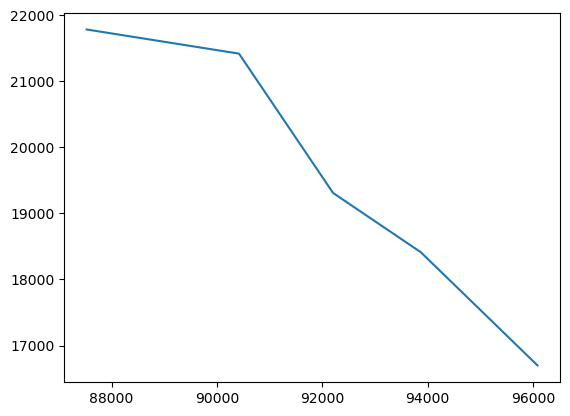

In [54]:
plt.plot(Tracks[Tracks.cell==cell].xt, Tracks[Tracks.cell==cell].yt)

In [68]:
parameters_segmentation={}
parameters_segmentation['target']='maximum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']= 0.5
parameters_segmentation['PBC_flag']="both"

In [90]:
mask, segmented_features = tobac.segmentation_2D(Tracks, lwp_selected, dxy = dxy, **parameters_segmentation, statistic = {'lwp_sum': np.sum})

In [86]:
segmented_features.lwp_sum

0        183.907349
1        146.681641
2        216.602692
3        129.918335
4        167.784943
           ...     
3125       348.9151
3126     239.748474
3127     724.996948
3128    1657.951538
3129    2272.483154
Name: lwp_sum, Length: 3130, dtype: object

In [107]:
segmented_features= segmented_features[segmented_features.cell > 0]
max_times = segmented_features.groupby('cell').time_cell.max()
# filter out cells that persist loonger than 30 minutes 
long_times= max_times[max_times >= np.timedelta64(30, "m")]
matched_cells = np.isin(segmented_features.cell, long_times.index)
long_lived_cells = segmented_features[matched_cells]

In [109]:
long_lived_cells.groupby('cell').time.


In [79]:
segmented_features[segmented_features.ncells == 0]

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,yt,xt,member,ncells
43,0,152,865.040575,1471.689181,74,1,44,2020-02-02 10:00:00,2020-02-02 10:00:00,86554.057468,147218.918051,147218.918051,0
571,6,215,1039.725773,1274.951688,62,1,572,2020-02-02 10:30:00,2020-02-02 10:30:00,104022.577252,127545.168758,127545.168758,0
1291,14,149,1011.047509,1134.272860,253,1,1292,2020-02-02 11:10:00,2020-02-02 11:10:00,101154.750885,113477.285997,113477.285997,0
1753,21,41,165.090957,393.400167,220,1,1754,2020-02-02 11:45:00,2020-02-02 11:45:00,16559.095696,39390.016708,39390.016708,0
2399,31,122,897.186673,375.493355,75,1,2400,2020-02-02 12:35:00,2020-02-02 12:35:00,89768.667256,37599.335506,37599.335506,0
2438,32,79,321.565780,1202.855257,76,1,2439,2020-02-02 12:40:00,2020-02-02 12:40:00,32206.577967,120335.525721,120335.525721,0


In [66]:
np.unique(mask)

array([   0,   44,  572, 1292, 1754, 2400, 2439], dtype=int32)

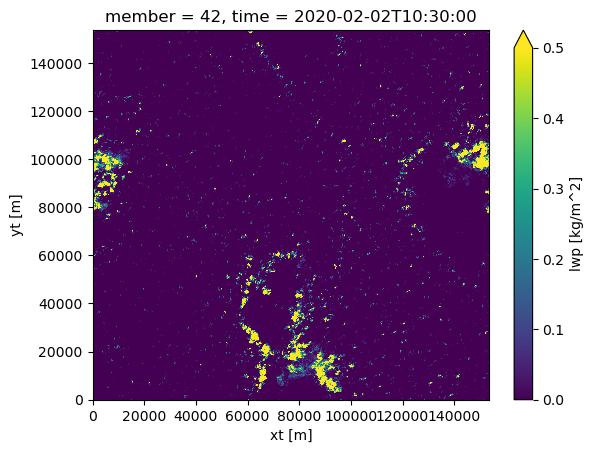

In [80]:
tt = 6

lwp_selected[tt].plot(vmax = 0.5)

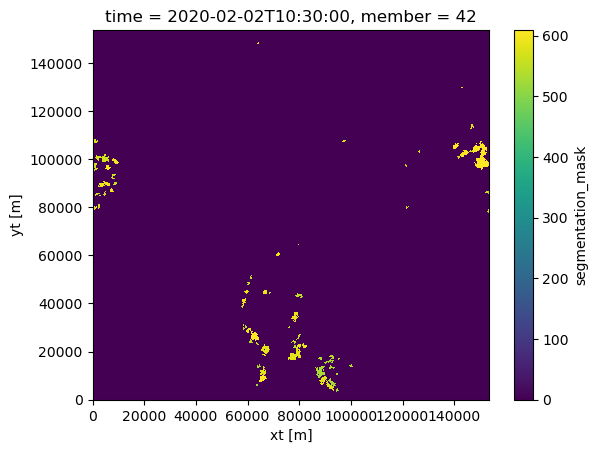

In [81]:
mask[tt].plot()